This notebook outlines the preprocessing workflow for configuring a Non-Hydrostatic FVCOM model aimed at simulating internal wave generation and plume dynamics at the thermal vent site Fåvne. The workflow is organized into the following sections:

FVCOM source code

Mesh generation

Bathymetry setup

Initial, surface, and open boundary forcing

In [66]:
import os
#os.chdir("/mnt/c/Users/qin/OneDrive - Akvaplan-niva AS/private/Dokumenter/GitHub/TURBOT-FVCOM")
print(os.getcwd())

/mnt/c/Users/qin/OneDrive - Akvaplan-niva AS/private/Dokumenter/GitHub/TURBOT-FVCOM


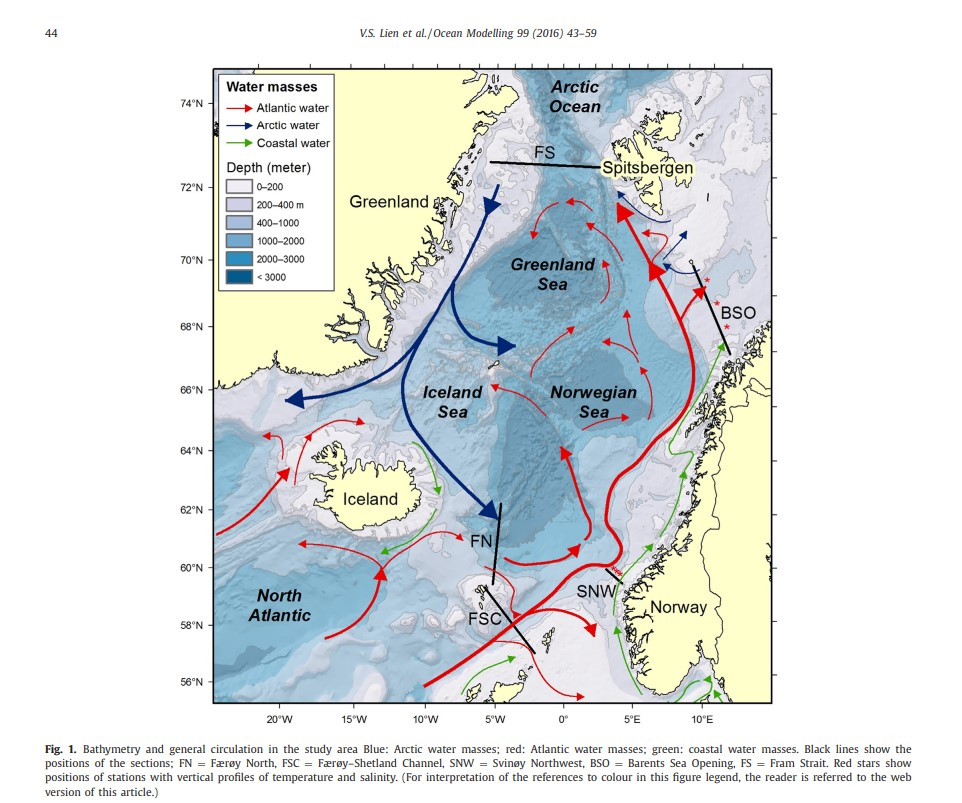

In [14]:
from IPython.display import Image
Image(filename='./Images/NordicSeasCirculation.jpg')

The FVCOM source code will be based on FVCOM5, complied with the late version of PETSC and Gfortran. The source code and make.in files are saved at on Betzy: /cluster/home/qin/fvcom-semi/FVCOM_chen/src.
The modules necessary to compile the semi-implicit and NH modules are : netCDF-Fortran/4.6.1-gompi-2023a and  PETSc/3.20.3-foss-2023a.
It is different from our way of using FVCOM-cmake compilation method.

Two sets of meshes will be set up, one coarse-res and one fine-res meshes. They are identical in model domain and horizontal resolution in most of the region except intimacy of 
the vent (1-3 km radius), where the coarse-res will use about 2-3 km and the fine-resolution will use 100-m  resolution. We will run the hydrostatic simulation with the
corase-res mesh to bring the current and hydrograph to a reasonal state using a 3D tidal simulation, which will provide initial conditions for the NH simulations with the 
fine-res mesh. 

Examining the circulation in Nordic Seas, we choose the open boundaries which can effectively capture the inflows into and outflows out of the Nordic Seas in order to get the background circulation at the Fåvne and surrounding areas right or reasonable.  For doing so, we need to make use of the climatology of mean velocity field and bathymetry from TOPAZ. We downloaded the yearly (1991-2024) velocity, salinity, temperature, and zeta fields together with model depth from https://data.marine.copernicus.eu/product/ARCTIC_MULTIYEAR_PHY_002_003/download?dataset=cmems_mod_arc_phy_my_topaz4_P1Y_202506 and saved them as *_TOPAZ.nc on Betzy: 
/cluster/projects/nn9238k/qin/TURBOT/TOPAZ.  By using nco commands, I took the time-average fields as the climatology (mk_clm.sh) and saved it as UV_TOPAZ_clm.nc. 

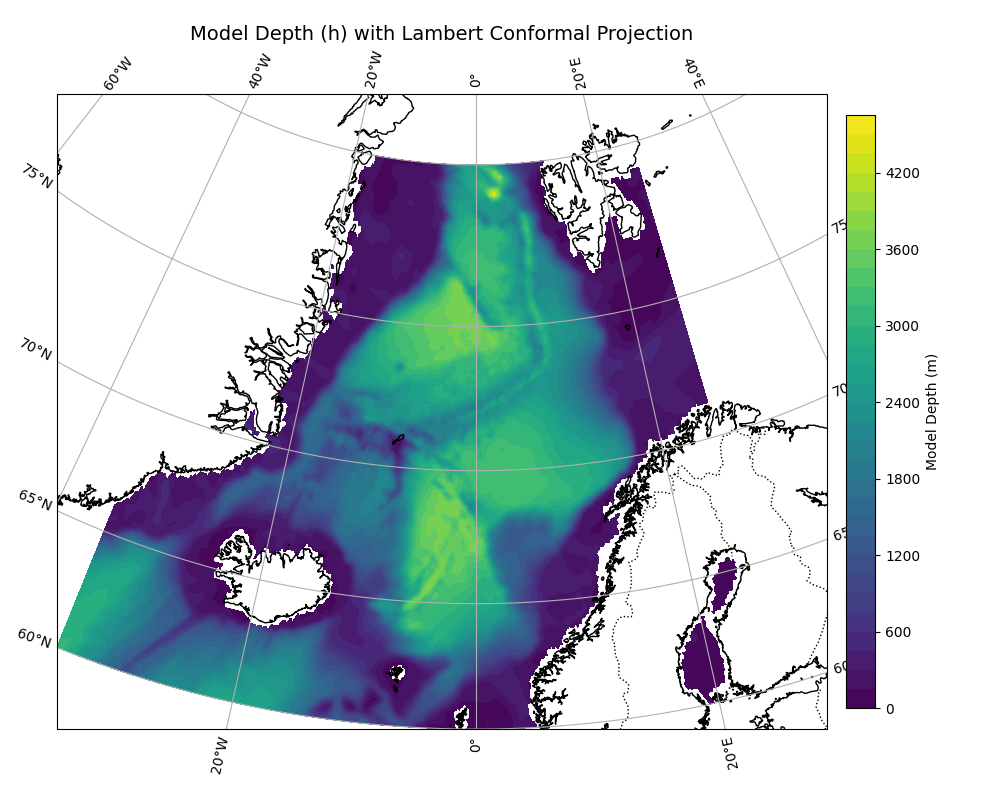

In [57]:
# Explore the bathymetry used in TOPAZ

import netCDF4 as nc
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# --- Load data ---
ds = nc.Dataset("/mnt/c/Users/Qin/DataDisk/TURBOT/TOPAZ_clm.nc")
lat = ds.variables["latitude"][:]
lon = ds.variables["longitude"][:]
h = ds.variables["model_depth"][:, :]  # shape: (lat, lon)

# --- Create meshgrid ---
lon2d, lat2d = np.meshgrid(lon, lat)

# 

# --- Plot with Cartopy ---
fig = plt.figure(figsize=(10, 8))
proj = ccrs.LambertConformal(central_longitude=0, central_latitude=70)
ax = plt.axes(projection=proj)

# Add coastlines and gridlines
ax.coastlines(resolution='10m')
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)

# Contour plot with correct projection
cp = ax.contourf(lon2d, lat2d, h, transform=ccrs.PlateCarree(),
                 cmap='viridis', levels=30)

# Colorbar
cbar = plt.colorbar(cp, orientation='vertical', pad=0.02, shrink=0.8)
cbar.set_label('Model Depth (m)')

# Title
ax.set_title('Model Depth (h) with Lambert Conformal Projection', fontsize=14)

plt.tight_layout()
plt.show()


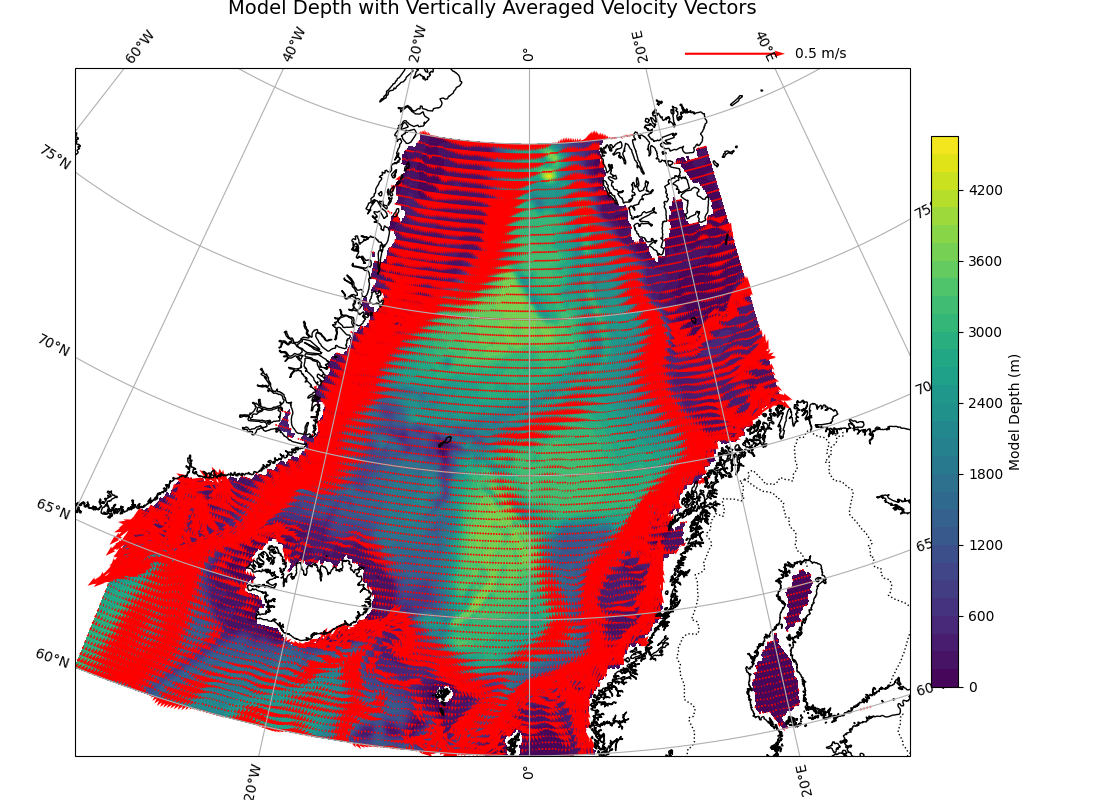

In [95]:
# Extract bathymetry and vertical mean velocity fields to determine open boundaries

import netCDF4 as nc
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

%matplotlib widget

# --- Load data ---
ds = nc.Dataset("/mnt/c/Users/Qin/DataDisk/TURBOT/TOPAZ_clm.nc")
lat = ds.variables["latitude"][:]             # (161,)
lon = ds.variables["longitude"][:]            # (417,)
h = ds.variables["model_depth"][:, :]         # (lat, lon)
vxo = ds.variables["vxo"][:, :, :]            # (depth, lat, lon)
vyo = ds.variables["vyo"][:, :, :]            # (depth, lat, lon)

# --- Create 2D grids ---
lon2d, lat2d = np.meshgrid(lon, lat)

# --- Compute vertical mean velocities ---
u_mean = np.nanmean(vxo, axis=0)              # shape: (lat, lon)
v_mean = np.nanmean(vyo, axis=0)              # shape: (lat, lon)

# --- Subsample for quiver plot (e.g., every 6th point) ---
step =2
lon_q = lon2d[::step, ::step]
lat_q = lat2d[::step, ::step]
u_q = u_mean[::step, ::step]
v_q = v_mean[::step, ::step]

# --- Set up plot ---
fig = plt.figure(figsize=(11, 8))
proj = ccrs.LambertConformal(central_longitude=0, central_latitude=70)
ax = plt.axes(projection=proj)

# --- Add features ---
ax.coastlines(resolution='10m')
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)

# --- Plot filled contours of depth ---
cp = ax.contourf(lon2d, lat2d, h, transform=ccrs.PlateCarree(),
                 cmap='viridis', levels=30)

# --- Add velocity arrows ---
qv = ax.quiver(lon_q, lat_q, u_q, v_q, transform=ccrs.PlateCarree(),
               scale=0.5, scale_units='inches', color='r', width=0.0025)

plt.quiverkey(qv, X=0.85, Y=1.02, U=0.5, label='0.5 m/s', labelpos='E')

# --- Colorbar ---
cbar = plt.colorbar(cp, orientation='vertical', pad=0.02, shrink=0.8)
cbar.set_label('Model Depth (m)')

# --- Title ---
ax.set_title('Model Depth with Vertically Averaged Velocity Vectors', fontsize=14)
plt.tight_layout()
plt.show()


### 📌 Candidate Lines for Open Boundary Definition based on the above field

| **Strait Region**                    | **Suggested Line**                                             | **Selection Method**                                                                 |
|-------------------------------------|----------------------------------------------------------------|---------------------------------------------------------------------------------------|
| **North (Greenland–Svalbard)**      | Near latitude **78.5°N**, connecting Greenland to Svalbard     | Fix latitude at 78.5° and identify the longitude range |
| **Southwest (Greenland–Iceland)**   | Near latitude **66.45°N**                                       | Fix latitude at 66.45° and identify the longitude range |
| **South-Central (Iceland–Faroe)**   | Straight line across the open gap                              | 64° at the Iceland side, and 62.5° at the Faroe sie
| **Southeast (Faroe–Shetland)**      | Across the narrow channel                                      | 62° at the Faroe side, and 60.75° at the Shetland side
| **South (Shetland–UK)**             | Near **60.5°N**, away from strong currents                     | Fix latitude at 60.5° and identify the longitude range where land  |
| **East (Barents–Norwegian boundary)**| Irregular line avoiding strong inflow                         | Define a custom path guided by the mean flow velocity field |


In [100]:
# Extract open boundaries along selected latitudes and 20°E longitude

import netCDF4 as nc
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import pyproj
import os

# --- Load data ---
ds = nc.Dataset("/mnt/c/Users/Qin/DataDisk/TURBOT/TOPAZ_clm.nc")
lat = ds.variables["latitude"][:]             # (161,)
lon = ds.variables["longitude"][:]            # (417,)
h = ds.variables["model_depth"][:, :]         # (lat, lon)

# --- Create 2D grids ---
lon2d, lat2d = np.meshgrid(lon, lat)          # shape (lat, lon)

# --- Define projection: EPSG:3413 = NS polar stereographic ---
proj_geo = pyproj.CRS("EPSG:4326")            # lat/lon
proj_ps = pyproj.CRS("EPSG:3413")             # polar stereographic
transformer = pyproj.Transformer.from_crs(proj_geo, proj_ps, always_xy=True)

# --- Output directory ---
output_dir = "./coastlines"
os.makedirs(output_dir, exist_ok=True)

# === A. Extract fixed-latitude open boundaries ===
target_lats = [78.5, 66.45, 64, 62, 62.5, 60.75, 60.5]

for lat_target in target_lats:
    idx = np.argmin(np.abs(lat - lat_target))
    lat_val = lat[idx]
    
    lon_line = lon2d[idx, :]
    h_line = h[idx, :]
    
    wet_mask = (h_line > 0) & np.isfinite(h_line)
    lon_valid = lon_line[wet_mask]
    lat_valid = np.full_like(lon_valid, lat_val)
    
    x, y = transformer.transform(lon_valid, lat_valid)
    
    outfile = os.path.join(output_dir, f"openbnd_{lat_val:.2f}N.txt")
    np.savetxt(outfile, np.c_[x, y], fmt="%.3f", header="x(m)    y(m)")
    
    print(f"Saved {len(x)} points for {lat_val:.2f}°N to {outfile}")

# === B. Extract fixed-longitude open boundary at 20°E ===
target_lon = 20.0
jdx = np.argmin(np.abs(lon - target_lon))
lon_val = lon[jdx]

lat_line = lat2d[:, jdx]
h_line = h[:, jdx]

wet_mask = (h_line > 0) & np.isfinite(h_line)
lat_valid = lat_line[wet_mask]
lon_valid = np.full_like(lat_valid, lon_val)

x, y = transformer.transform(lon_valid, lat_valid)

outfile = os.path.join(output_dir, f"openbnd_{lon_val:.2f}E.txt")
np.savetxt(outfile, np.c_[x, y], fmt="%.3f", header="x(m)    y(m)")

print(f"Saved {len(x)} points for {lon_val:.2f}°E to {outfile}")




Saved 270 points for 78.50°N to ./coastlines/openbnd_78.50N.txt
Saved 349 points for 66.50°N to ./coastlines/openbnd_66.50N.txt
Saved 314 points for 64.00°N to ./coastlines/openbnd_64.00N.txt
Saved 338 points for 62.00°N to ./coastlines/openbnd_62.00N.txt
Saved 348 points for 62.50°N to ./coastlines/openbnd_62.50N.txt
Saved 333 points for 60.75°N to ./coastlines/openbnd_60.75N.txt
Saved 314 points for 60.50°N to ./coastlines/openbnd_60.50N.txt
Saved 84 points for 20.00°E to ./coastlines/openbnd_20.00E.txt


/tmp/ipykernel_26465/2693296600.py:38: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig = plt.figure(figsize=(10, 7))


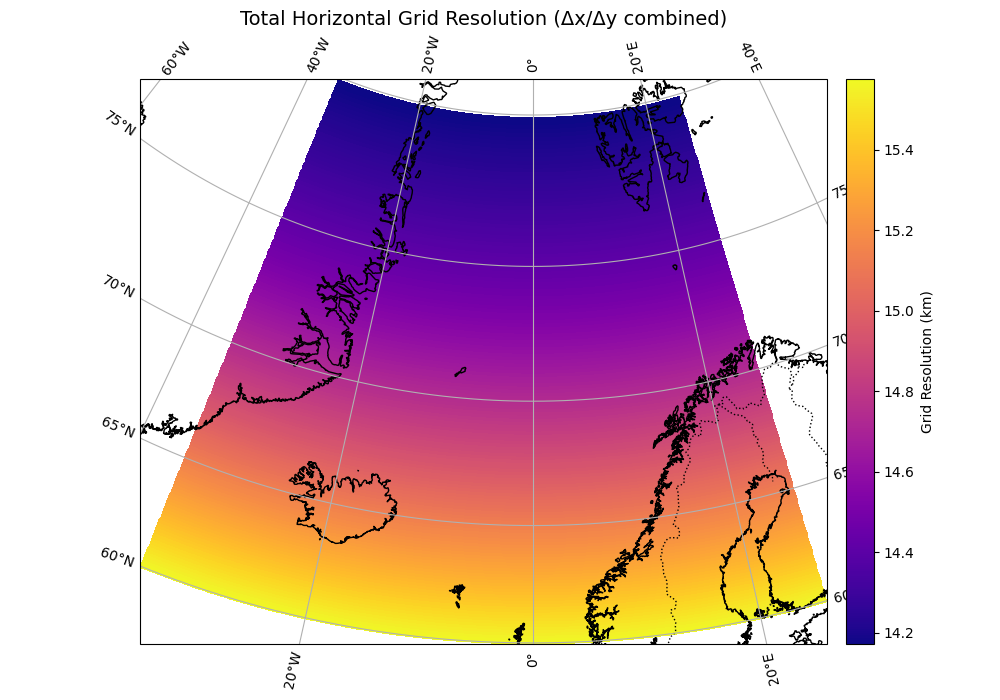

In [63]:
# Check the grid resolution
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from pyproj import Geod

# --- Assume lat2d, lon2d are your input arrays (shape: ny, nx)
ny, nx = lat2d.shape
geod = Geod(ellps="WGS84")

# --- Compute dx (zonal resolution) along rows (constant lat)
dx_km = np.zeros((ny, nx - 1))
for i in range(ny):
    lons1 = lon2d[i, :-1]
    lons2 = lon2d[i, 1:]
    lats = lat2d[i, :-1]
    az12, az21, dx = geod.inv(lons1, lats, lons2, lats)
    dx_km[i, :] = dx / 1000  # convert to km

# --- Compute dy (meridional resolution) along columns (constant lon)
dy_km = np.zeros((ny - 1, nx))
for j in range(nx):
    lats1 = lat2d[:-1, j]
    lats2 = lat2d[1:, j]
    lons = lon2d[:-1, j]
    az12, az21, dy = geod.inv(lons, lats1, lons, lats2)
    dy_km[:, j] = dy / 1000  # convert to km

# --- Combine dx and dy to compute overall grid spacing (res_km)
res_km = np.sqrt(dx_km[:-1, :]**2 + dy_km[:, :-1]**2)  # shape: (ny-1, nx-1)

# --- Prepare matching lat/lon for plotting
lat_crop = lat2d[:-1, :-1]
lon_crop = lon2d[:-1, :-1]

# --- Plot using Cartopy
fig = plt.figure(figsize=(10, 7))
proj = ccrs.LambertConformal(central_longitude=0, central_latitude=70)
ax = plt.axes(projection=proj)

# Add coastlines and gridlines
ax.coastlines(resolution="10m")
ax.add_feature(cfeature.BORDERS, linestyle=":")
ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)

# Plot resolution field
pcm = ax.pcolormesh(lon_crop, lat_crop, res_km, cmap='plasma',
                    shading='auto', transform=ccrs.PlateCarree())
cbar = plt.colorbar(pcm, ax=ax, orientation='vertical', pad=0.02)
cbar.set_label("Grid Resolution (km)")

# Title and layout
ax.set_title("Total Horizontal Grid Resolution (Δx/Δy combined)", fontsize=14)
plt.tight_layout()
plt.show()


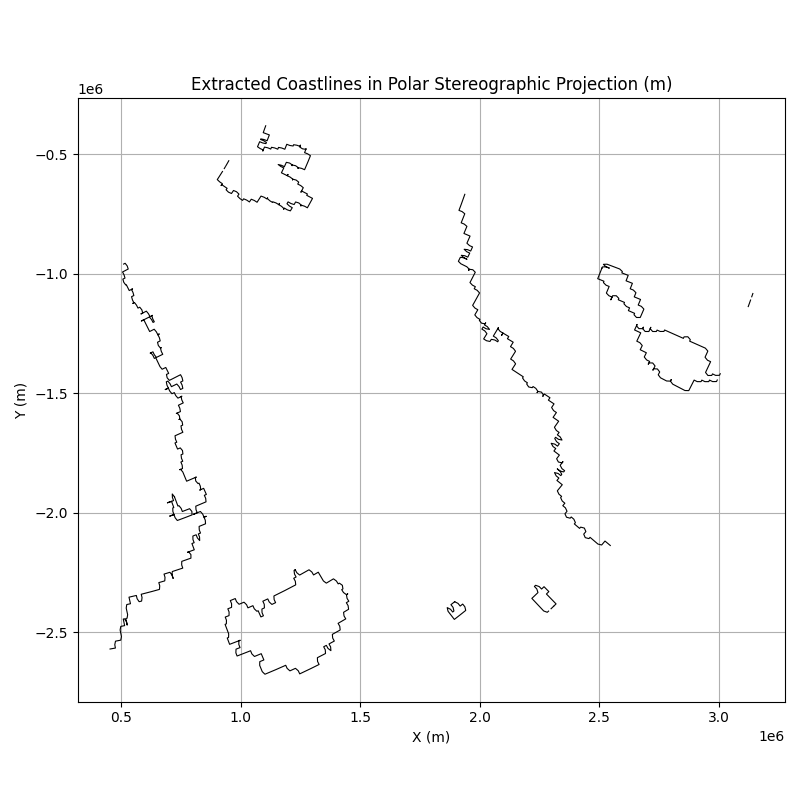

✅ Coastline saved to: model_coastline_stereographic.dat


In [90]:
# Extracting coastline and save it to a coast.txt 
import numpy as np
from skimage import measure
from pyproj import Transformer
import matplotlib.pyplot as plt

# --- Load data ---
ds = nc.Dataset("/mnt/c/Users/Qin/DataDisk/TURBOT/TOPAZ_clm.nc")
lat = ds.variables["latitude"][:]             # (161,)
lon = ds.variables["longitude"][:]            # (417,)
h = ds.variables["model_depth"][:, :]         # (lat, lon)

# --- Create 2D grids ---
lon2d, lat2d = np.meshgrid(lon, lat)          # shape (lat, lon)

# --- Define coastline mask (land or shallow < 10 m) ---
coast_mask = np.isnan(h.data)

# --- Extract coastline contours from mask boundary ---
contours = measure.find_contours(coast_mask.astype(float), level=0.5)

# --- Define projection: Polar Stereographic (EPSG:3413, NSIDC standard) ---
transformer = Transformer.from_crs("epsg:4326", "epsg:3413", always_xy=True)

# --- Optional: visualize the coastline in projected x/y (km) ---
fig, ax = plt.subplots(figsize=(8, 8))
ax.set_title("Extracted Coastlines in Polar Stereographic Projection (m)")
ax.set_xlabel("X (m)")
ax.set_ylabel("Y (m)")

# --- Prepare output file in SMS COAST format ---
output_file = "model_coastline_stereographic.dat"
with open(output_file, "w") as f:
    f.write("COAST\n")
    f.write(f"{len(contours)}\n")  # number of segments

    for contour in contours:
        # Convert fractional contour coordinates to index
        y_idx, x_idx = contour.T
        y_idx = np.clip(np.round(y_idx).astype(int), 0, lat2d.shape[0] - 1)
        x_idx = np.clip(np.round(x_idx).astype(int), 0, lon2d.shape[1] - 1)

        # Look up lat/lon along the contour
        lon_line = lon2d[y_idx, x_idx]
        lat_line = lat2d[y_idx, x_idx]

        # Convert to polar stereographic (meters)
        x_m, y_m = transformer.transform(lon_line, lat_line)
        
        # Save to file
        f.write(f"{len(x_m)} 1\n")
        for x, y in zip(x_m, y_m):
            f.write(f"{x:.4f} {y:.4f}\n")

        # Also plot
        ax.plot(x_m, y_m, 'k-', linewidth=0.8)

ax.set_aspect('equal')
ax.grid(True)
plt.tight_layout()
plt.show()

print(f"✅ Coastline saved to: {output_file}")


✅ Coastline X range: 453007.8095 to 3142109.7656
✅ Coastline Y range: -2674626.9841 to -380201.3567
📌 OBC 60.5°N: X = 567017.3 to 2950292.1, Y = -3215715.1 to -1399324.4
📌 OBC 66.5°N: X = 486864.2 to 2158076.7, Y = -2534204.4 to -1414897.1
📌 OBC 78.5°N: X = 547873.7 to 1181703.7, Y = -1123307.6 to -406893.2


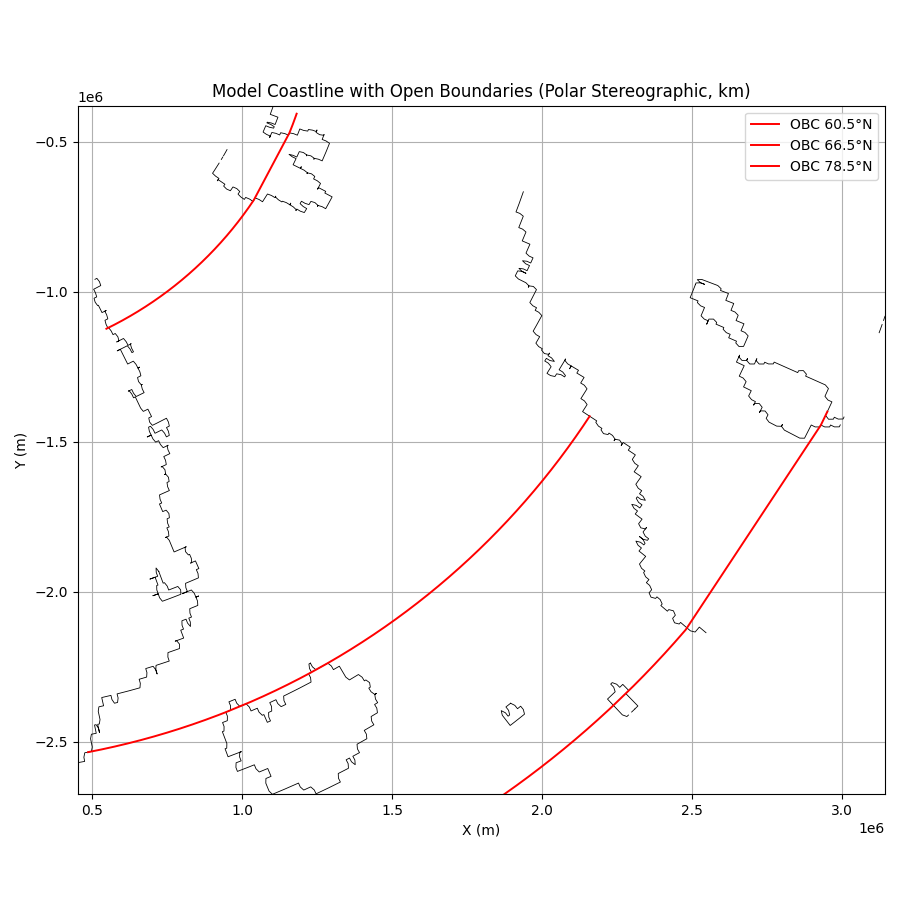

In [92]:
# plot coastlines and latitude-related obc
import numpy as np
import matplotlib.pyplot as plt

# --- Load SMS-style coastline file ---
def load_sms_coast(filename):
    with open(filename, 'r') as f:
        lines = f.readlines()
        n_segments = int(lines[1].strip())
        coords = []
        idx = 2
        for _ in range(n_segments):
            npts = int(lines[idx].split()[0])
            idx += 1
            segment = []
            for _ in range(npts):
                x, y = map(float, lines[idx].split())
                segment.append((x, y))
                idx += 1
            coords.append(np.array(segment))
    return coords

# --- Paths ---
coast_file = "./coastlines/model_coastline_stereographic.dat"
obc_paths = {
    "60.5°N": "./coastlines/openbnd_60.50N.txt",
    "66.5°N": "./coastlines/openbnd_66.50N.txt",
    "78.5°N": "./coastlines/openbnd_78.50N.txt"
}

# --- Load data ---
coast_segments = load_sms_coast(coast_file)
obc_lines = {label: np.loadtxt(path) for label, path in obc_paths.items()}

# --- Print ranges for debugging ---
all_x = np.concatenate([seg[:, 0] for seg in coast_segments])
all_y = np.concatenate([seg[:, 1] for seg in coast_segments])
print("✅ Coastline X range:", all_x.min(), "to", all_x.max())
print("✅ Coastline Y range:", all_y.min(), "to", all_y.max())

for label, data in obc_lines.items():
    print(f"📌 OBC {label}: X = {data[:,0].min():.1f} to {data[:,0].max():.1f}, "
          f"Y = {data[:,1].min():.1f} to {data[:,1].max():.1f}")

# --- Plot ---
fig, ax = plt.subplots(figsize=(9, 9))
ax.set_title("Model Coastline with Open Boundaries (Polar Stereographic, km)")
ax.set_xlabel("X (m)")
ax.set_ylabel("Y (m)")

# Plot coastline
for seg in coast_segments:
    ax.plot(seg[:, 0], seg[:, 1], 'k-', linewidth=0.6)

# Plot OBCs
for label, data in obc_lines.items():
    ax.plot(data[:, 0], data[:, 1], 'r-', linewidth=1.4, label=f"OBC {label}")

# Set plot limits to encompass everything
margin = 100  # km
ax.set_xlim(all_x.min() - margin, all_x.max() + margin)
ax.set_ylim(all_y.min() - margin, all_y.max() + margin)

ax.legend()
ax.set_aspect('equal')
ax.grid(True)
plt.tight_layout()
plt.show()


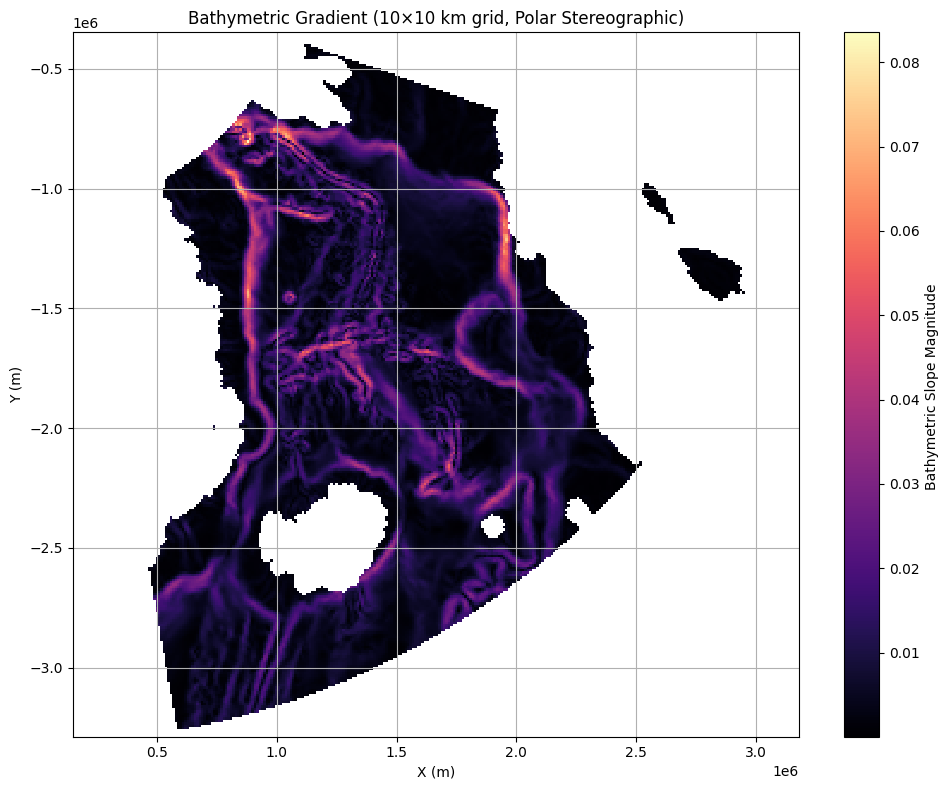

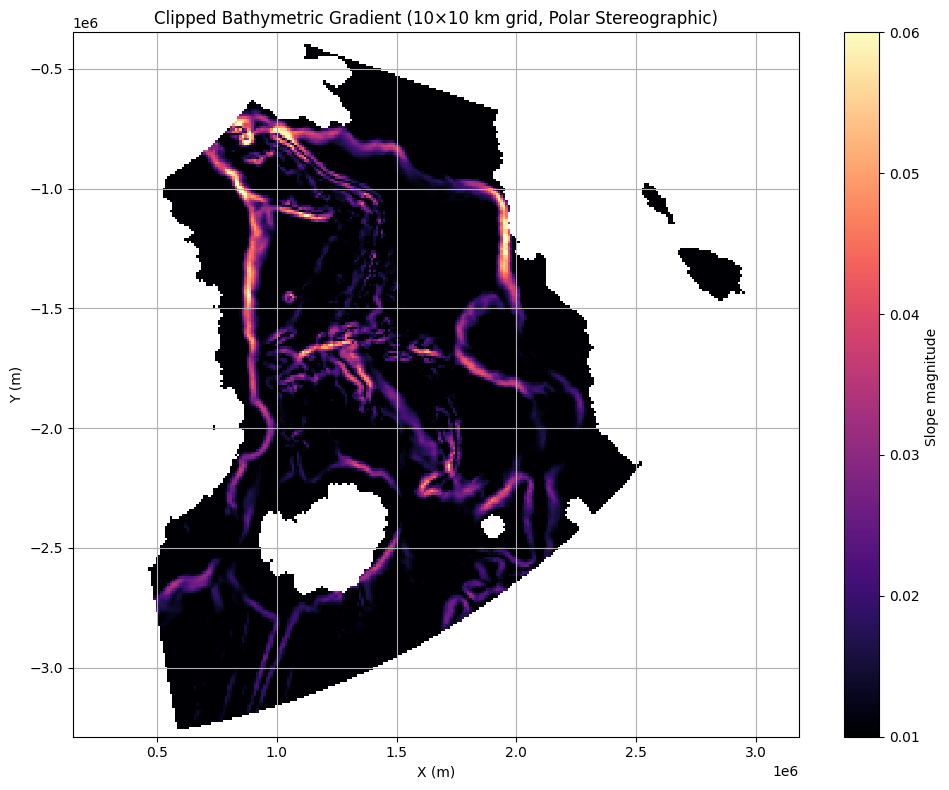

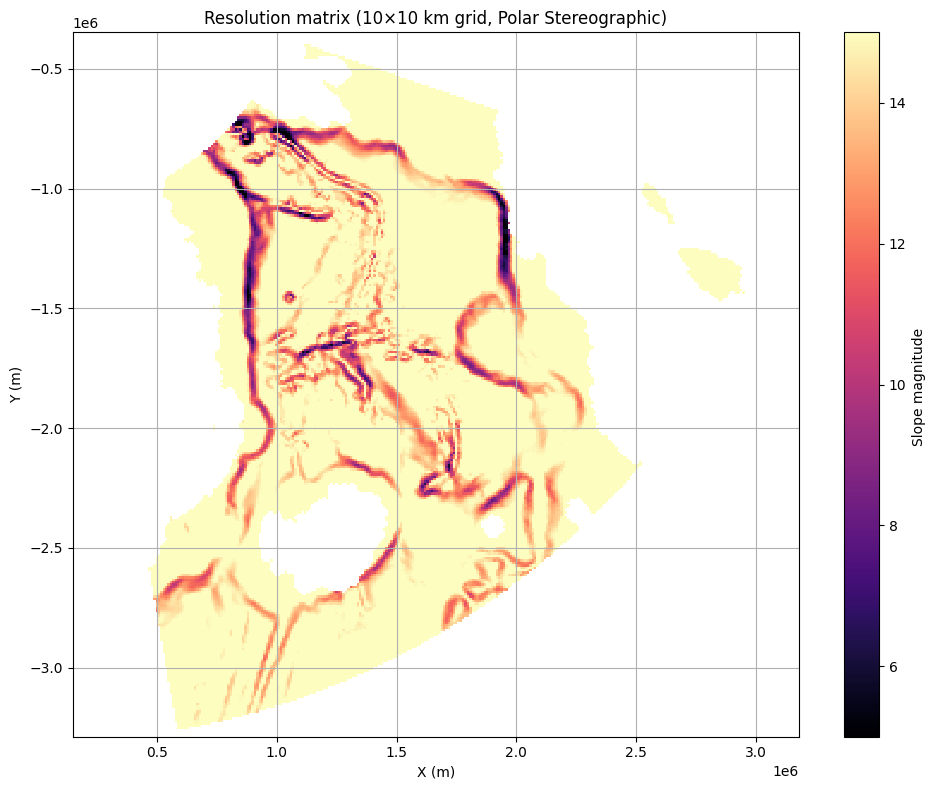

In [17]:
import netCDF4 as nc
import numpy as np
from scipy.ndimage import gaussian_filter
import matplotlib.pyplot as plt
from scipy.interpolate import griddata
import pyproj

# --- Assumed Inputs ---
# --- Load data ---
ds = nc.Dataset("/mnt/c/Users/Qin/DataDisk/TURBOT/TOPAZ_clm.nc")
lat = ds.variables["latitude"][:]             # (161,)
lon = ds.variables["longitude"][:]            # (417,)
h = ds.variables["model_depth"][:, :]         # (lat, lon)

# --- Create 2D grids ---
lon2d, lat2d = np.meshgrid(lon, lat)          # shape (lat, lon)


# --- Convert lat/lon to Polar Stereographic (x/y in km) ---
proj_geo = pyproj.CRS("EPSG:4326")     # Geographic
proj_ps = pyproj.CRS("EPSG:3413")      # Polar stereographic
transformer = pyproj.Transformer.from_crs(proj_geo, proj_ps, always_xy=True)

lon_flat = lon2d.flatten()
lat_flat = lat2d.flatten()
h_flat = h.flatten()

x_flat, y_flat = transformer.transform(lon_flat, lat_flat)

# --- Create Regular 10 km Grid ---
dx = dy = 10000  # km resolution
x_range = np.arange(x_flat.min(), x_flat.max(), dx)
y_range = np.arange(y_flat.min(), y_flat.max(), dy)
x_grid, y_grid = np.meshgrid(x_range, y_range)

# --- Interpolate h onto the regular grid ---
h_interp = griddata(
    points=(x_flat, y_flat),
    values=h_flat,
    xi=(x_grid, y_grid),
    method="linear"
)

# --- Compute gradient (in m/km) ---
dh_dx, dh_dy = np.gradient(h_interp, dx, dy)
slope_mag = np.sqrt(dh_dx**2 + dh_dy**2)

# --- Plot slope magnitude ---
plt.figure(figsize=(10, 8))
pc = plt.pcolormesh(x_grid, y_grid, slope_mag, shading='auto', cmap='magma')
plt.colorbar(pc, label='Bathymetric Slope Magnitude ')

# Add contours of bathymetry
#contours = plt.contour(x_grid, y_grid, h_interp, levels=10, colors='white', linewidths=0.5)
#plt.clabel(contours, fmt="%.0f", fontsize=8)

plt.title("Bathymetric Gradient (10×10 km grid, Polar Stereographic)")
plt.xlabel("X (m)")
plt.ylabel("Y (m)")
plt.axis("equal")
plt.grid(True)
plt.tight_layout()
plt.show()



# Clip slopt between 0.01 and 0.06
slope_clipped = np.clip(slope_mag, 0.01, 0.06)

# Compute resoltion matrix based on slope

res_km = 15 - (slope_clipped - 0.01) * (10 / 0.05)

# Smooth the resolution matrix using Gaussian filter
sigma = 1
slope_smooth =  gaussian_filter(slope_mag, sigma=sigma)



# Optional: plot the smoothed slope and resolution matrix
plt.figure(figsize=(10, 8))
pc = plt.pcolormesh(x_grid, y_grid, slope_clipped, shading='auto', cmap='magma')
plt.colorbar(pc, label='Slope magnitude ')

plt.title("Clipped Bathymetric Gradient (10×10 km grid, Polar Stereographic)")
plt.xlabel("X (m)")
plt.ylabel("Y (m)")
plt.axis("equal")
plt.grid(True)
plt.tight_layout()
plt.show()

# Optional: plot the smoothed slope and resolution matrix
plt.figure(figsize=(10, 8))
pc = plt.pcolormesh(x_grid, y_grid, res_km, shading='auto', cmap='magma')
plt.colorbar(pc, label='Slope magnitude ')

plt.title("Resolution matrix (10×10 km grid, Polar Stereographic)")
plt.xlabel("X (m)")
plt.ylabel("Y (m)")
plt.axis("equal")
plt.grid(True)
plt.tight_layout()
plt.show()



Reference

@article{lien2016assessment,
  title={An assessment of the added value from data assimilation on modelled Nordic Seas hydrography and ocean transports},
  author={Lien, Vidar S and Hj{\o}llo, Solfrid S and Skogen, Morten D and Svendsen, Einar and Wehde, Henning and Bertino, Laurent and Counillon, Francois and Chevallier, Matthieu and Garric, Gilles},
  journal={Ocean Modelling},
  volume={99},
  pages={43--59},
  year={2016},
  publisher={Elsevier}
}